# Project in SML 


Capital Bikeshare is a 24-hour public bicycle-sharing system that serves Washington, D.C., and which offers transportation for thousands of people throughout the city. The problem that arises is that there are certain occasions when, due to various circumstances, there are not as many bikes available as there are demands. In the long term, this situation will result in more people taking the car instead of the bicycle, increasing CO2 emissions in the city. To tackle this situation, the District Department of Transportation in the city wants to know if at certain hours an increase in the number of bikes available will be necessary.
The goal of the project is to predict whether an increase in the number of bikes is necessary or not based on various temporal and meteorological data. You are expected to use all the knowledge that you have acquired in the course about classification algorithms, to come up with one model that you think is suited for this problem and which you decide to put ‘in production’. This model will then be tested against a test set made available after peer review.

Method to be implemented
(i) Logistic regression
(ii) Discriminant analysis: LDA, QDA
(iii) K-nearest neighbor
(iv) Tree-based methods: classification trees, random forests, bagging
(v) Boosting


In [4]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.random
from keras.callbacks import TensorBoard
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV



In [5]:
dftrain = pd.read_csv('training_data.csv')
dftrain
#dftest = pd.read_csv('test.csv')

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.000,0,0.0,16.3,31.6,16.0,low_bike_demand
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.000,0,0.0,23.9,85.7,16.0,low_bike_demand
2,21,3,8,0,1,1,26.9,21.8,73.39,0.000,0,0.0,0.0,81.1,16.0,low_bike_demand
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.000,0,0.0,19.2,0.0,16.0,low_bike_demand
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.000,0,0.0,10.5,44.6,16.0,low_bike_demand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3,5,6,0,0,1,21.5,19.4,87.68,0.000,0,0.0,10.6,24.4,16.0,low_bike_demand
1596,14,0,6,0,1,1,23.2,20.1,82.43,2.217,0,0.0,9.8,92.1,10.4,low_bike_demand
1597,13,0,3,0,1,1,13.9,-2.2,32.93,0.000,0,2.0,18.2,79.3,16.0,low_bike_demand
1598,14,5,3,0,0,1,11.7,-9.3,22.09,0.000,0,0.0,5.8,24.4,16.0,high_bike_demand


# Feature Building

We can see that all constant values over all the 16000 datapoints it's not necessary to have because they don't tell the alghorimt anything. This is for examople the case with snowdepth. 

In [6]:
# Good weather =1 bad weather =0

featurebuild = []

for i in range(1600):
    if dftrain['temp'][i] > 10 and dftrain['windspeed'][i] < 10 and dftrain['cloudcover'][i] < 50:
        featurebuild.append(1)
    else:
        featurebuild.append(0)


In [7]:
count_of_ones = featurebuild.count(1)
print(count_of_ones)

162


In [8]:
#Temp difference is usually a good feature to build,#inital value of 0
tempdiff = [0] 
for i in range(1599):
    value=dftrain['temp'][i+1]-dftrain['temp'][i]
    tempdiff.append(value)

len(tempdiff)




1600

In [9]:
dftrain['tempdiff'] = tempdiff
dftrain['featurebuild'] = featurebuild


#drop snowdepth coloumn

#dftrain = dftrain.drop('snowdepth', axis=1)
dftrain

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock,tempdiff,featurebuild
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.000,0,0.0,16.3,31.6,16.0,low_bike_demand,0.0,0
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.000,0,0.0,23.9,85.7,16.0,low_bike_demand,5.9,0
2,21,3,8,0,1,1,26.9,21.8,73.39,0.000,0,0.0,0.0,81.1,16.0,low_bike_demand,28.2,0
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.000,0,0.0,19.2,0.0,16.0,low_bike_demand,-23.8,0
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.000,0,0.0,10.5,44.6,16.0,low_bike_demand,8.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3,5,6,0,0,1,21.5,19.4,87.68,0.000,0,0.0,10.6,24.4,16.0,low_bike_demand,-1.7,0
1596,14,0,6,0,1,1,23.2,20.1,82.43,2.217,0,0.0,9.8,92.1,10.4,low_bike_demand,1.7,0
1597,13,0,3,0,1,1,13.9,-2.2,32.93,0.000,0,2.0,18.2,79.3,16.0,low_bike_demand,-9.3,0
1598,14,5,3,0,0,1,11.7,-9.3,22.09,0.000,0,0.0,5.8,24.4,16.0,high_bike_demand,-2.2,1


In [10]:
column_names = dftrain.columns
column_names

Index(['hour_of_day', 'day_of_week', 'month', 'holiday', 'weekday',
       'summertime', 'temp', 'dew', 'humidity', 'precip', 'snow', 'snowdepth',
       'windspeed', 'cloudcover', 'visibility', 'increase_stock', 'tempdiff',
       'featurebuild'],
      dtype='object')

In [11]:
#time=range(1600)
#for i in range(dftrain.shape[1]):
#    plt.figure()  
#    plt.scatter(time,dftrain.iloc[:,i].values)
#    plt.title(f"Time Series for {column_names[i]}")  # Add title with column name


In [12]:
# Create the target vector
# 0 - low_bike_demand
# 1 - high_bike_demand

target_vect = dftrain.loc[:,'increase_stock'].to_numpy()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# One hot encoder for the data
enc = OneHotEncoder()
target_names = ['low_bike_demand','high_bike_demand']
target = enc.fit_transform(target_vect[:, np.newaxis]).toarray()

In [13]:
Target=pd.DataFrame(target)
Target

,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
1595,0.0,1.0
1596,0.0,1.0
1597,0.0,1.0
1598,1.0,0.0


In [14]:
# Split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    dftrain.iloc[:,0:15], Target.iloc[:,0], test_size=0.1,)#random_state=2)

In [15]:
dftrain.iloc[:,0:16]

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.000,0,0.0,16.3,31.6,16.0,low_bike_demand
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.000,0,0.0,23.9,85.7,16.0,low_bike_demand
2,21,3,8,0,1,1,26.9,21.8,73.39,0.000,0,0.0,0.0,81.1,16.0,low_bike_demand
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.000,0,0.0,19.2,0.0,16.0,low_bike_demand
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.000,0,0.0,10.5,44.6,16.0,low_bike_demand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3,5,6,0,0,1,21.5,19.4,87.68,0.000,0,0.0,10.6,24.4,16.0,low_bike_demand
1596,14,0,6,0,1,1,23.2,20.1,82.43,2.217,0,0.0,9.8,92.1,10.4,low_bike_demand
1597,13,0,3,0,1,1,13.9,-2.2,32.93,0.000,0,2.0,18.2,79.3,16.0,low_bike_demand
1598,14,5,3,0,0,1,11.7,-9.3,22.09,0.000,0,0.0,5.8,24.4,16.0,high_bike_demand


In [16]:
dftrain.iloc[:,0:15]

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.000,0,0.0,16.3,31.6,16.0
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.000,0,0.0,23.9,85.7,16.0
2,21,3,8,0,1,1,26.9,21.8,73.39,0.000,0,0.0,0.0,81.1,16.0
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.000,0,0.0,19.2,0.0,16.0
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.000,0,0.0,10.5,44.6,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3,5,6,0,0,1,21.5,19.4,87.68,0.000,0,0.0,10.6,24.4,16.0
1596,14,0,6,0,1,1,23.2,20.1,82.43,2.217,0,0.0,9.8,92.1,10.4
1597,13,0,3,0,1,1,13.9,-2.2,32.93,0.000,0,2.0,18.2,79.3,16.0
1598,14,5,3,0,0,1,11.7,-9.3,22.09,0.000,0,0.0,5.8,24.4,16.0


In [17]:
model = keras.Sequential([
    layers.InputLayer(input_shape=(15,)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

2023-11-29 10:37:44.703061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.summary() 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1024      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)


In [21]:
epoch=150
history_callback = model.fit(X_train, Y_train,
                                 batch_size=64,
                                 epochs=epoch,
                                 verbose=1,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[early_stopping_callback])

Epoch 1/150
23/23 [==============================] - 1s 7ms/step - loss: 0.6520 - accuracy: 0.6333 - val_loss: 0.6244 - val_accuracy: 0.8125
Epoch 2/150
23/23 [==============================] - 0s 2ms/step - loss: 0.5457 - accuracy: 0.7271 - val_loss: 0.5332 - val_accuracy: 0.8125
Epoch 3/150
23/23 [==============================] - 0s 2ms/step - loss: 0.4596 - accuracy: 0.8021 - val_loss: 0.4844 - val_accuracy: 0.8125
Epoch 4/150
23/23 [==============================] - 0s 2ms/step - loss: 0.4517 - accuracy: 0.7951 - val_loss: 0.4437 - val_accuracy: 0.8125
Epoch 5/150
23/23 [==============================] - 0s 2ms/step - loss: 0.4326 - accuracy: 0.8132 - val_loss: 0.4206 - val_accuracy: 0.8125
Epoch 6/150
23/23 [==============================] - 0s 2ms/step - loss: 0.4050 - accuracy: 0.8188 - val_loss: 0.4077 - val_accuracy: 0.8062
Epoch 7/150
23/23 [==============================] - 0s 2ms/step - loss: 0.4005 - accuracy: 0.8257 - val_loss: 0.4017 - val_accuracy: 0.8062
Epoch 8/150
2

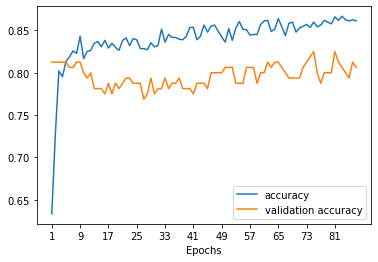

In [23]:
def plot_accuracy(fit, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, fit.history['accuracy'], label='accuracy')
    plt.plot(iterations, fit.history['val_accuracy'],
             label='validation accuracy')
    plt.legend()
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_accuracy(history_callback, 87)

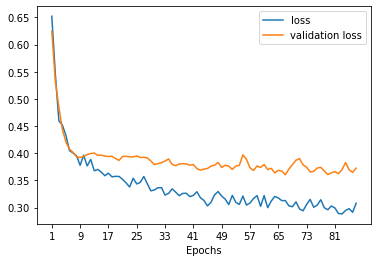

In [24]:
def plot_loss(fit, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, fit.history['loss'], label='loss')
    plt.plot(iterations, fit.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_loss(history_callback, 87)

In [25]:
pred = model.predict(X_test)
print(pred)

5/5 [==============================] - 0s 849us/step
[[8.41967110e-03]
 [4.83484641e-02]
 [1.74252165e-03]
 [1.46496762e-02]
 [4.33847308e-01]
 [2.22418364e-03]
 [1.77559312e-02]
 [3.40442091e-01]
 [6.67540014e-01]
 [6.62983221e-05]
 [3.51605676e-02]
 [1.06893065e-04]
 [2.16756836e-02]
 [1.23712060e-03]
 [1.70270465e-02]
 [5.83823740e-01]
 [4.91454542e-01]
 [3.99269126e-02]
 [4.09980893e-01]
 [1.55382296e-02]
 [6.55813282e-03]
 [7.88326748e-03]
 [3.80308856e-03]
 [1.87211201e-01]
 [1.06909582e-04]
 [9.40656289e-02]
 [1.67801082e-01]
 [3.54256392e-01]
 [5.46973385e-03]
 [6.61362335e-02]
 [6.63471639e-01]
 [1.32281855e-02]
 [6.14968187e-04]
 [6.61039591e-01]
 [1.23620231e-03]
 [2.09877081e-02]
 [1.31355137e-01]
 [5.70269108e-01]
 [1.26786500e-01]
 [6.77332520e-01]
 [5.47705352e-01]
 [3.03942919e-01]
 [3.35115790e-01]
 [4.23334599e-01]
 [2.89742704e-02]
 [8.12811137e-04]
 [2.01022968e-01]
 [3.16010346e-03]
 [7.24194944e-02]
 [4.99784410e-01]
 [6.82489872e-01]
 [1.30770579e-01]
 [2.1436780

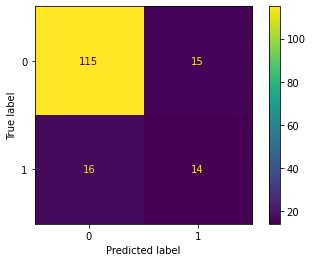

In [26]:
predicted = tensorflow.squeeze(pd.DataFrame(pred))
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(Y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

In [27]:
predictedtest = tensorflow.squeeze(pd.DataFrame(pred))
predictedtest = np.array([1 if x >= 0.5 else 0 for x in predictedtest])
predictedtest

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0])

In [28]:
Result=[]
for i in predictedtest:
    if i==0:
        Result.append('low_bike_demand')
    else:
        Result.append('high_bike_demand')

In [29]:
Result

['low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'high_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'high_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'high_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'high_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'high_bike_demand',
 'low_bike_demand',
 'high_bike_demand',
 'high_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_demand',
 'low_bike_de

In [30]:
accuracy_score(actual, predicted)


0.80625

# Gaussian Naive Bayes

In [31]:
# Split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    dftrain.iloc[:,0:15], Target.iloc[:,0], test_size=0.1, shuffle=True)#random_state=2)

In [32]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, Y_train)

# Predict Output
predicted = model.predict(X_test)

print("Actual Value:", Y_test)
print("Predicted Value:", predicted)

Actual Value: 648     0.0
1092    0.0
1270    1.0
1566    1.0
1345    0.0
       ... 
128     1.0
1428    0.0
1181    0.0
167     0.0
1       0.0
Name: 0, Length: 160, dtype: float64
Predicted Value: [1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.]


In [33]:
y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, Y_test)

print("Accuracy:", accuray)


Accuracy: 0.4375


# Discriminant analysis


In [34]:
model = LinearDiscriminantAnalysis()


In [35]:
Parameters={
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 0.1, 0.5, 0.9],
    'priors': [None, [0.4, 0.6], [0.6, 0.4], [0.5, 0.5]],
    'n_components': [None, 2, 3, 4]  # Depending on the number of features in your dataset
}

In [36]:
clf = GridSearchCV(model, Parameters, scoring='accuracy', refit=True)


In [37]:
clf.fit(X_train, Y_train)

/Users/anton/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
800 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/anton/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/anton/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/anton/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py", line 637, in fit
    self._solve_

GridSearchCV(estimator=LinearDiscriminantAnalysis(),
             param_grid={'n_components': [None, 2, 3, 4],
                         'priors': [None, [0.4, 0.6], [0.6, 0.4], [0.5, 0.5]],
                         'shrinkage': [None, 0.1, 0.5, 0.9],
                         'solver': ['svd', 'lsqr', 'eigen']},
             scoring='accuracy')

In [38]:
best_params =clf.best_params_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd'}


In [39]:
model = LinearDiscriminantAnalysis(solver='svd')

In [40]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.846 (0.027)


In [41]:
# fit model
model.fit(X_train, Y_train)
# make a prediction
yhat = model.predict(X_test)
# summarize prediction
print('Predicted Class: ', yhat)

Predicted Class:  [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [42]:
y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, Y_test)

print("Accuracy:", accuray)

Accuracy: 0.85


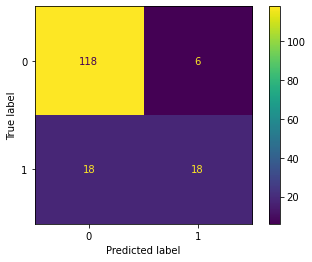

In [43]:
predicted = tensorflow.squeeze(pd.DataFrame(y_pred))
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(Y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()